In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation

In [2]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Video Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy(gain=0.0).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device=device)

ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(couzin_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
#expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  1000
Storage of Prey Expert Buffer:  32000 



[PREDATOR] Epoch 01 | Train Loss: 0.302294 | Val Loss: 0.543975
[PREDATOR] Epoch 02 | Train Loss: 0.305558 | Val Loss: 0.826540
[PREDATOR] Epoch 03 | Train Loss: 0.340208 | Val Loss: 0.558134
[PREDATOR] Epoch 04 | Train Loss: 0.376557 | Val Loss: 0.737611
[PREDATOR] Epoch 05 | Train Loss: 0.356201 | Val Loss: 0.549937
[PREDATOR] Epoch 06 | Train Loss: 0.264818 | Val Loss: 0.588976
[PREDATOR] Epoch 07 | Train Loss: 0.329097 | Val Loss: 0.637491
[PREDATOR] Epoch 08 | Train Loss: 0.261394 | Val Loss: 0.521032
[PREDATOR] Epoch 09 | Train Loss: 0.319150 | Val Loss: 0.393460
[PREDATOR] Epoch 10 | Train Loss: 0.411461 | Val Loss: 0.421946
[PREDATOR] Epoch 11 | Train Loss: 0.332232 | Val Loss: 0.491938
[PREDATOR] Epoch 12 | Train Loss: 0.405246 | Val Loss: 0.586267
[PREDATOR] Epoch 13 | Train Loss: 0.213983 | Val Loss: 0.646619
[PREDATOR] Epoch 14 | Train Loss: 0.238107 | Val Loss: 0.545211
[PREDATOR] Epoch 15 | Train Loss: 0.260720 | Val Loss: 0.257376
[PREDATOR] Epoch 16 | Train Loss: 0.2272

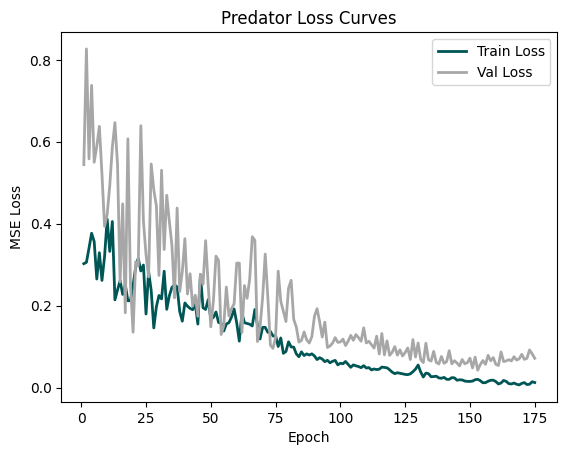

In [5]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, prey_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=500, lr=1e-3, early_stopping=True, patience=100)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

In [6]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, pred_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=10000, lr=1e-3, early_stopping=True, patience=20)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

tensor([0.0313, 0.0312, 0.0312,  ..., 0.0312, 0.0312, 0.0312],
       grad_fn=<MeanBackward1>)
[PREY] Epoch 01 | Train Loss: 0.436904 | Val Loss: 0.406561 | Pred Gain: 0.0312500037252903
tensor([0.0312, 0.0312, 0.0313,  ..., 0.0312, 0.0312, 0.0312],
       grad_fn=<MeanBackward1>)
[PREY] Epoch 02 | Train Loss: 0.455366 | Val Loss: 0.408194 | Pred Gain: 0.03125
tensor([0.0312, 0.0312, 0.0312,  ..., 0.0312, 0.0312, 0.0312],
       grad_fn=<MeanBackward1>)
[PREY] Epoch 03 | Train Loss: 0.448004 | Val Loss: 0.457156 | Pred Gain: 0.03124999813735485
tensor([0.0312, 0.0313, 0.0312,  ..., 0.0312, 0.0312, 0.0312],
       grad_fn=<MeanBackward1>)
[PREY] Epoch 04 | Train Loss: 0.425453 | Val Loss: 0.448895 | Pred Gain: 0.03124999813735485
tensor([0.0312, 0.0312, 0.0312,  ..., 0.0313, 0.0312, 0.0312],
       grad_fn=<MeanBackward1>)
[PREY] Epoch 05 | Train Loss: 0.440048 | Val Loss: 0.408861 | Pred Gain: 0.03125
tensor([0.0312, 0.0312, 0.0312,  ..., 0.0312, 0.0313, 0.0312],
       grad_fn=<MeanBa

KeyboardInterrupt: 

In [ ]:
env = parallel_env(use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.


ValueError: not enough values to unpack (expected 9, got 8)